# CNN to classify dog breeds

## Importing packages

In [ ]:
from os import listdir
from matplotlib import pyplot
from matplotlib import image
import numpy as np
from PIL import Image
import pandas as pd
import tensorflow as tf
import keras

## Getting data

In [ ]:
train_path = "C:\\Users\\rajma\\Desktop\\Datasets\\dog_breeds\\train\\"
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_path,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 7946 files belonging to 70 classes.


In [ ]:
test_path = "C:\\Users\\rajma\\Desktop\\Datasets\\dog_breeds\\test\\"
valid_path = "C:\\Users\\rajma\\Desktop\\Datasets\\dog_breeds\\valid\\"

test_dataset = tf.keras.utils.image_dataset_from_directory(test_path,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

valid_dataset = tf.keras.utils.image_dataset_from_directory(valid_path,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)


Found 700 files belonging to 70 classes.
Found 700 files belonging to 70 classes.


In [ ]:
# type(train_dataset)

In [ ]:
class_names = train_dataset.class_names

In [ ]:
print(len(train_dataset.take(250)), "\n")
for images, labels in train_dataset.take(1):
    print(len(images))
    print(type(images))
    print(type(images[0]))
    print(images[0].shape)
#     print(labels.shape)
    


249 

32
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(160, 160, 3)


In [ ]:
train_dataset_batches = tf.data.experimental.cardinality(train_dataset)
train_dataset_batches

<tf.Tensor: shape=(), dtype=int64, numpy=249>

In [ ]:
249*32

7968

In [ ]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 10))
# for images, labels in train_dataset.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

## Configure the dataset for performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
valid_dataset = valid_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Data Augmentation to increase dataset and reduce overfitting

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

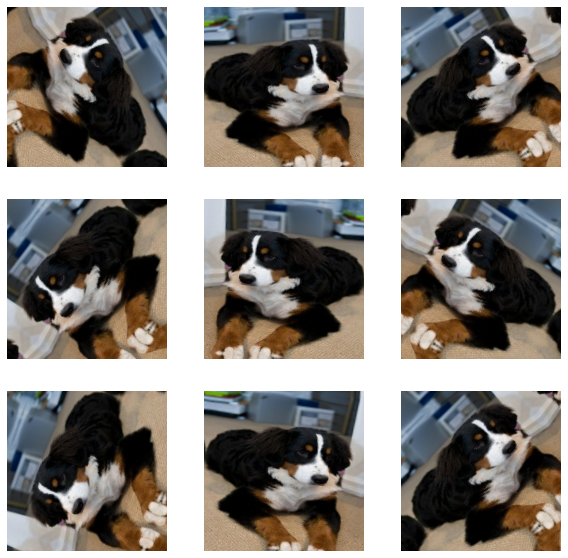

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Rescaling image pixels

Some models takes pixels values from [0,1] while some take values [-1,1]. So we need to adjust out dataset according to the range of pixel values in the model.

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
type(preprocess_input(first_image))

tensorflow.python.framework.ops.EagerTensor

In [ ]:
temp = (preprocess_input(first_image)).numpy()
print("Max pixel value : ", temp.max())
print("Min pixel value : ", temp.min())

Max pixel value :  0.9573333
Min pixel value :  -1.0


In [ ]:
# Alternative 
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

## Create base model with pre-trained weights

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_dataset))

In [ ]:
(image_batch.shape)

TensorShape([32, 160, 160, 3])

#### This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [ ]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's `trainable` flag to False will freeze all of them.

In [ ]:
base_model.trainable = False

### Important note about BatchNormalization layers

Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions should be taken in the context of fine-tuning, as shown later in this tutorial. 

When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will not update its mean and variance statistics. 

When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

For more details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
prediction_batch

<tf.Tensor: shape=(32, 1), dtype=float32, numpy=
array([[ 0.59891266],
       [ 1.1509035 ],
       [ 1.0562723 ],
       [ 1.2991198 ],
       [ 0.8457586 ],
       [ 0.89450794],
       [ 0.34885165],
       [ 1.5200176 ],
       [ 0.26612636],
       [-0.5136719 ],
       [ 0.38566303],
       [ 1.7791395 ],
       [ 0.06000832],
       [ 0.81538177],
       [ 0.42287672],
       [-0.10268975],
       [ 1.4225893 ],
       [ 1.2149357 ],
       [ 0.2266899 ],
       [ 1.2950051 ],
       [ 0.7053081 ],
       [-0.2340227 ],
       [-0.6571138 ],
       [ 1.5692462 ],
       [ 1.1682454 ],
       [ 1.297255  ],
       [-0.29073772],
       [ 0.8017669 ],
       [ 1.2454075 ],
       [ 1.3265765 ],
       [ 1.4101304 ],
       [ 1.7399229 ]], dtype=float32)>

Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, use `training=False` as our model contains a `BatchNormalization` layer.

In [ ]:
# inputs = tf.keras.Input(shape=(160, 160, 3))
# x = data_augmentation(inputs)
# x = preprocess_input(x)
# x = base_model(x, training=False)
# x = global_average_layer(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# outputs = tf.keras.layers.Dense(1)(x)

# model = tf.keras.Model(inputs, outputs)

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)

# x=base_model.output
x = base_model(x, training=False)

x=global_average_layer(x)
x=tf.keras.layers.Dropout(0.2)(x)
x=tf.keras.layers.Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=tf.keras.layers.Dense(1024,activation='relu')(x) #dense layer 2
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Dense(512,activation='relu')(x) #dense layer 3
x=tf.keras.layers.Dropout(0.2)(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Dense(256,activation='relu')(x) 
x=tf.keras.layers.Dropout(0.2)(x)
preds=tf.keras.layers.Dense(70,activation='softmax')(x)

model = tf.keras.Model(inputs=inputs,outputs=preds)


In [ ]:
base_model.input

<KerasTensor: shape=(None, 160, 160, 3) dtype=float32 (created by layer 'input_1')>

In [ ]:
inputs

<KerasTensor: shape=(None, 160, 160, 3) dtype=float32 (created by layer 'input_2')>

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

## Number of Learning varaibles 

In [ ]:
len(model.trainable_variables)

14

## Training the model

In [ ]:
initial_epochs = 25

loss0, accuracy0 = model.evaluate(valid_dataset)

22/22 [==============================] - 8s 146ms/step - loss: 4.2901 - accuracy: 0.0143


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 4.29
initial accuracy: 0.01


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=valid_dataset)

Epoch 1/25
249/249 [==============================] - 41s 136ms/step - loss: 3.1929 - accuracy: 0.2723 - val_loss: 1.4091 - val_accuracy: 0.7786
Epoch 2/25
249/249 [==============================] - 34s 135ms/step - loss: 1.5898 - accuracy: 0.5955 - val_loss: 0.5386 - val_accuracy: 0.8971
Epoch 3/25
249/249 [==============================] - 34s 136ms/step - loss: 1.1695 - accuracy: 0.6832 - val_loss: 0.4681 - val_accuracy: 0.9157
Epoch 4/25
249/249 [==============================] - 34s 136ms/step - loss: 0.9996 - accuracy: 0.7211 - val_loss: 0.4418 - val_accuracy: 0.9129
Epoch 5/25
249/249 [==============================] - 34s 136ms/step - loss: 0.9038 - accuracy: 0.7405 - val_loss: 0.4671 - val_accuracy: 0.9029
Epoch 6/25
249/249 [==============================] - 34s 136ms/step - loss: 0.8403 - accuracy: 0.7537 - val_loss: 0.4722 - val_accuracy: 0.9200
Epoch 7/25
249/249 [==============================] - 34s 136ms/step - loss: 0.7652 - accuracy: 0.7754 - val_loss: 0.4545 - val_ac

### Note: If you are wondering why the validation metrics are clearly better than the training metrics, the main factor is because layers like tf.keras.layers.BatchNormalization and tf.keras.layers.Dropout affect accuracy during training. They are turned off when calculating validation loss.

### To a lesser extent, it is also because training metrics report the average for an epoch, while validation metrics are evaluated after the epoch, so validation metrics see a model that has trained slightly longer.

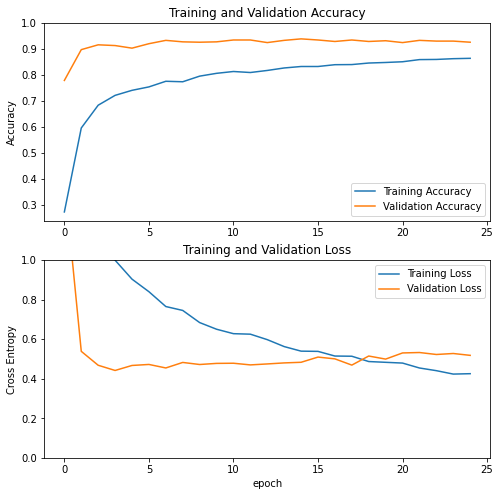

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

All you need to do is unfreeze the base_model and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.



In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
#base_learning_rate = 0.0001
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

68

In [ ]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=valid_dataset)

Epoch 25/45
249/249 [==============================] - 67s 212ms/step - loss: 0.4130 - accuracy: 0.8674 - val_loss: 0.5174 - val_accuracy: 0.9343
Epoch 26/45
249/249 [==============================] - 51s 203ms/step - loss: 0.3831 - accuracy: 0.8752 - val_loss: 0.5268 - val_accuracy: 0.9314
Epoch 27/45
249/249 [==============================] - 51s 202ms/step - loss: 0.3676 - accuracy: 0.8862 - val_loss: 0.5243 - val_accuracy: 0.9300
Epoch 28/45
249/249 [==============================] - 51s 202ms/step - loss: 0.3489 - accuracy: 0.8843 - val_loss: 0.5303 - val_accuracy: 0.9314
Epoch 29/45
249/249 [==============================] - 51s 202ms/step - loss: 0.3353 - accuracy: 0.8914 - val_loss: 0.5239 - val_accuracy: 0.9343
Epoch 30/45
249/249 [==============================] - 50s 202ms/step - loss: 0.3211 - accuracy: 0.8955 - val_loss: 0.5268 - val_accuracy: 0.9300
Epoch 31/45
249/249 [==============================] - 50s 202ms/step - loss: 0.3154 - accuracy: 0.8966 - val_loss: 0.5149 -

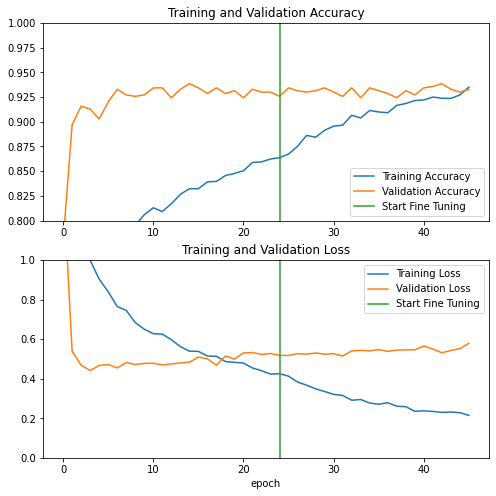

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Evaluation and prediction on single image

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
print(image_batch[0].shape)
label_batch[0]

(160, 160, 3)


54

In [ ]:
prediction = model.predict(tf.expand_dims(image_batch[0], axis=0))

In [ ]:
prediction.shape

(1, 70)

In [ ]:
prediction_softmax = tf.nn.softmax(prediction)
prediction_softmax.shape

TensorShape([1, 70])

In [ ]:
np.sum(prediction_softmax.numpy()) #sum of softmax output is 1

1.0

In [ ]:
index = tf.argmax(input=tf.nn.softmax(prediction_softmax), axis=1)
index = index.numpy()


In [ ]:
print("True ans : ",class_names[label_batch[0]])
print("Predicted ans : ",class_names[index[0]])


True ans :  Pekinese
Predicted ans :  Pekinese


# Proper evaluation on batch

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

22/22 [==============================] - 3s 111ms/step - loss: 0.1242 - accuracy: 0.9600
Test accuracy : 0.9599999785423279


In [ ]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
pred = model.predict_on_batch(image_batch)

In [ ]:
pred.shape

(32, 70)

In [ ]:
pred_softmax = tf.nn.softmax(pred, axis=0)

In [ ]:
pred_softmax.shape

TensorShape([32, 70])

In [ ]:
Y_pred = tf.argmax(input=pred, axis=1)
Y_pred.shape

TensorShape([32])

In [ ]:
label_batch

array([58,  3, 34, 20, 46, 15,  2, 33, 59, 13, 29, 38,  0, 69,  0, 47, 68,
       37, 51, 27, 34, 19, 56, 12, 68, 16, 40, 18, 18, 27, 53, 21])

In [ ]:
Y_pred.numpy()

array([58,  3, 34, 16, 46, 15,  2, 33, 59, 13, 29, 38,  0, 69,  0, 47, 68,
       37, 51, 27, 34, 19, 56, 12, 68, 16, 40, 18, 18, 27, 53, 21],
      dtype=int64)

In [ ]:
print('Predictions:\n', Y_pred.numpy())
print('Labels:\n', label_batch)

Predictions:
 [58  3 34 16 46 15  2 33 59 13 29 38  0 69  0 47 68 37 51 27 34 19 56 12
 68 16 40 18 18 27 53 21]
Labels:
 [58  3 34 20 46 15  2 33 59 13 29 38  0 69  0 47 68 37 51 27 34 19 56 12
 68 16 40 18 18 27 53 21]


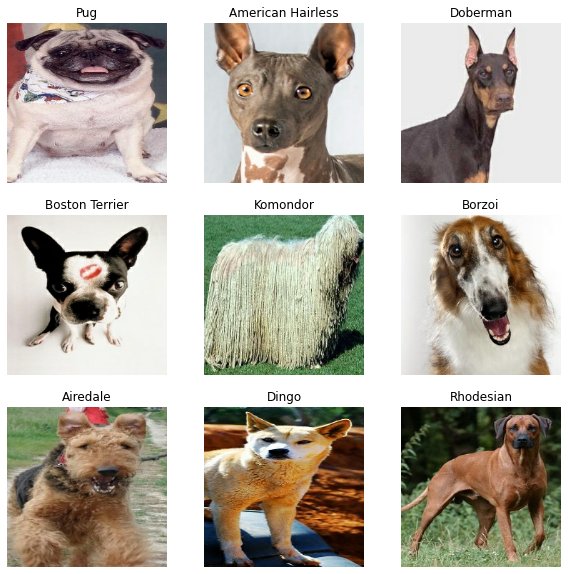

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[Y_pred[i]])
  plt.axis("off")

# Resnet Model

In [ ]:
preprocess_input_resnet = tf.keras.applications.resnet50.preprocess_input

In [ ]:
resnet_model = tf.keras.applications.resnet50.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
resnet_model.trainable = False

In [ ]:
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 166, 166, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 80, 80, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 80, 80, 64)   256         ['conv1_conv[0][0]']      

 conv2_block3_2_conv (Conv2D)   (None, 40, 40, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 40, 40, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 40, 40, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 40, 40, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 20, 20, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 20, 20, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 20, 20, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 20, 20, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_1_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 10, 10, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 10, 10, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 10, 10, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_block5_2_bn (BatchNormal  (None, 10, 10, 256)  1024       ['conv4_block5_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_2_relu (Activatio  (None, 10, 10, 256)  0          ['conv4_block5_2_bn[0][0]']      
 n)       

 conv5_block2_1_conv (Conv2D)   (None, 5, 5, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 5, 5, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 5, 5, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 5, 5, 512)    2359808     ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_blo

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input_resnet(x)

# x=base_model.output
x = resnet_model(x, training=False)

x=global_average_layer(x)
x=tf.keras.layers.Dropout(0.2)(x)
x=tf.keras.layers.Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=tf.keras.layers.Dense(1024,activation='relu')(x) #dense layer 2
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Dense(512,activation='relu')(x) #dense layer 3
x=tf.keras.layers.Dropout(0.2)(x)
x=tf.keras.layers.BatchNormalization()(x)
x=tf.keras.layers.Dense(256,activation='relu')(x) 
x=tf.keras.layers.Dropout(0.2)(x)
preds=tf.keras.layers.Dense(70,activation='softmax')(x)

model2 = tf.keras.Model(inputs=inputs,outputs=preds)


In [ ]:
base_learning_rate = 0.0001
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 160, 160, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 160, 160, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  multiple                 0         
 lobalAveragePooling2D)                                    

In [ ]:
initial_epochs = 20

Rloss0, Raccuracy0 = model2.evaluate(valid_dataset)

22/22 [==============================] - 12s 293ms/step - loss: 4.4276 - accuracy: 0.0100


In [ ]:
print("initial loss: {:.2f}".format(Rloss0))
print("initial accuracy: {:.2f}".format(Raccuracy0))

initial loss: 4.39
initial accuracy: 0.02


In [ ]:
history_resnet = model2.fit(train_dataset,
                    epochs=20,
                    validation_data=valid_dataset)

Epoch 1/50
249/249 [==============================] - 88s 319ms/step - loss: 3.1287 - accuracy: 0.2817 - val_loss: 1.1061 - val_accuracy: 0.7871
Epoch 2/50
249/249 [==============================] - 79s 316ms/step - loss: 1.5372 - accuracy: 0.6070 - val_loss: 0.5690 - val_accuracy: 0.8729
Epoch 3/50
249/249 [==============================] - 79s 316ms/step - loss: 1.1403 - accuracy: 0.6853 - val_loss: 0.4620 - val_accuracy: 0.9000
Epoch 4/50
249/249 [==============================] - 81s 324ms/step - loss: 0.9749 - accuracy: 0.7253 - val_loss: 0.4642 - val_accuracy: 0.9143
Epoch 5/50
249/249 [==============================] - 83s 333ms/step - loss: 0.8742 - accuracy: 0.7441 - val_loss: 0.4387 - val_accuracy: 0.9186
Epoch 6/50
249/249 [==============================] - 83s 331ms/step - loss: 0.7936 - accuracy: 0.7674 - val_loss: 0.4331 - val_accuracy: 0.9286
Epoch 7/50
249/249 [==============================] - 83s 331ms/step - loss: 0.7433 - accuracy: 0.7813 - val_loss: 0.4503 - val_ac

In [ ]:
Rloss, Raccuracy = model2.evaluate(test_dataset)

22/22 [==============================] - 5s 238ms/step - loss: 0.1690 - accuracy: 0.9557


In [ ]:
Rloss

0.16895140707492828

In [ ]:
Raccuracy

0.9557142853736877

## Fine tunning resnet

In [ ]:
resnet_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(resnet_model.layers))

Number of layers in the base model:  175


In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 135

# Freeze all the layers before the `fine_tune_at` layer
for layer in resnet_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
#base_learning_rate = 0.0001
model2.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001),
              metrics=['accuracy'])

In [ ]:
model2.summary()

In [ ]:
fine_tune_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs

history_fine_resnet = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=valid_dataset)

In [ ]:
loss, accuracy = model2.evaluate(test_dataset)
print('Test accuracy :', accuracy)